# SDS 2023 Forecasting & Meta Learning Workshop

In this notebook, we will get our hands dirty with Darts. We will do the following things:

* **Part 1:** Forecasting passenger counts series for 300 airlines (`air` dataset). We will train one model per series.
* **Part 2:** Using "global" models - i.e., models trained on all 300 series simultaneously. Here we split every timeseries into data from the trainset and data from the testset.
* **Part 3:** We will try some *meta learning*, and see what happens if we train some global models on one (big) dataset (`m4` dataset) and use them on another dataset. Compared to part 2, m4 is the trainset and m3 will be our testset.
* **Part 4:** We will reuse our pre-trained model(s) of Part 3 on another new dataset (`m3` dataset) and see how it compares to models specifically trained on this dataset.

## Part 0: Setup (No code to write - execute only)
First, we need to install the right libraries and make the right imports. For the deep learning models, it will help to use a GPU runtime. To get a GPU instance, click on the "RAM/Disk" info bars on the upper right, select "Change runtime type" and choose a GPU as hardware accelerator. The following command will show you the GPU available (if any). If there's no GPU available, you can still go ahead and work on CPU.

In [ ]:
# You can run this command to see if there's a GPU:
!nvidia-smi

Thu May 25 14:59:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install darts &> /dev/null
!pip install pyyaml==5.4.1 &> /dev/null
!pip install xlrd==2.0.1 &> /dev/null
!pip install matplotlib==3.1.3 &> /dev/null

In [ ]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import time
import random
import pandas as pd
import pickle
import numpy as np
import requests
import tqdm.notebook as tq
from datetime import datetime
import torch
from torch import nn
from typing import List, Tuple, Dict
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import seaborn as sns
from pytorch_lightning.callbacks import Callback, EarlyStopping

from darts import TimeSeries
from darts.utils.losses import SmapeLoss
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import smape, mase, mape
from darts.utils.data import HorizonBasedDataset
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode
from darts.models import (
    NaiveSeasonal, NBEATSModel, ExponentialSmoothing,
    TCNModel, RegressionModel, LinearRegressionModel, 
    LightGBMModel, ARIMA, Theta, KalmanForecaster
)

We define the forecast horizon here - for all of the (monthly) time series used in this notebook, we'll be interested in forecasting 18 months in advance. We pick 18 months as this is what is used in the M3/M4 competitions for monthly series.

In [ ]:
HORIZON = 18

### Datasets loading methods
Here, we define some helper methods to load the three datasets we'll be playing with: `air`, `m3` and `m4`. 

All the methods below return two list of `TimeSeries`: one list of training series and one list of "test" series (of length `HORIZON`).

For convenience, all the series are already scaled here, by multiplying each of them by a constant so that the largest value is 1. Such scaling is necessary for many models to work correctly (esp. deep learning models). It does not affect the sMAPE values, so we can evaluate the accuracy of our algorithms on the scaled series. In a real application, we would have to keep the Darts `Scaler` objects somewhere in order to inverse-scale the forecasts.

In [ ]:
# Execute this cell once to download all three datasets
!curl -L https://github.com/unit8co/sds2023-forecating-and-meta-learning/blob/main/data/m3_dataset.xls\?raw\=true -o m3_dataset.xls
!curl -L https://github.com/unit8co/sds2023-forecating-and-meta-learning/blob/main/data/passengers_per_carrier.csv\?raw\=true -o passengers_per_carrier.csv
!curl -L https://github.com/unit8co/sds2023-forecating-and-meta-learning/blob/main/data/m4_monthly_scaled.pkl\?raw\=true -o m4_monthly_scaled.pkl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1716k  100 1716k    0     0  1380k      0  0:00:01  0:00:01 --:--:-- 79.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1100k  100 1100k    0     0  1125k      0 --:--:-- --:--:-- --:--:-- 63.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:

In [ ]:
def load_m3() -> Tuple[List[TimeSeries], List[TimeSeries]]:
    print('building M3 TimeSeries...')

    # Read DataFrame
    df_m3 = (pd.read_excel('m3_dataset.xls', 'M3Month'))

    # Build TimeSeries
    m3_series = []
    for row in tq.tqdm(df_m3.iterrows(), position=0, leave=True):
        s = row[1]
        start_year = int(s['Starting Year'])
        start_month = int(s['Starting Month'])
        values_series = s[6:].dropna()
        if start_month == 0:
            continue
        
        start_date = datetime(year=start_year, month=start_month, day=1)
        time_axis = pd.date_range(start_date, periods=len(values_series))
        series = TimeSeries.from_times_and_values(time_axis, values_series.values).astype(np.float32)
        m3_series.append(series)

    print('\nThere are {} monthly series in the M3 dataset'.format(len(m3_series)))

    # Split train/test
    print('splitting train/test...')
    m3_train = [s[:-HORIZON] for s in m3_series]
    m3_test = [s[-HORIZON:] for s in m3_series]

    # Scale so that the largest value is 1
    print('scaling...')
    scaler_m3 = Scaler(scaler=MaxAbsScaler())
    m3_train_scaled: List[TimeSeries] = scaler_m3.fit_transform(m3_train)
    m3_test_scaled: List[TimeSeries] = scaler_m3.transform(m3_test)

    print('done. There are {} series, with average training length {}'.format(
        len(m3_train_scaled), np.mean([len(s) for s in m3_train_scaled])
    ))
    return m3_train_scaled, m3_test_scaled

def load_air() -> Tuple[List[TimeSeries], List[TimeSeries]]:
    df_per_carrier = pd.read_csv("/content/passengers_per_carrier.csv", dtype={"passengers": np.float32})
    df_per_carrier["month"] = df_per_carrier["month"].apply(pd.to_datetime)
    # Passenger filtering
    carriers_total_passenger = df_per_carrier.groupby("carrier_name").agg(total_passengers = ("passengers", "sum"))
    CARRIERS_TO_KEEP = carriers_total_passenger.query("total_passengers > 100000").index.values.tolist()
    df_per_carrier_filt = (
        df_per_carrier
        .query("carrier_name in @CARRIERS_TO_KEEP")
    )
    df_per_carrier_filt = df_per_carrier_filt.loc[:, ["carrier_name", "passengers", "month"]]
    min_len = 60
    air_data = TimeSeries.from_group_dataframe(df_per_carrier_filt, group_cols="carrier_name", value_cols="passengers", time_col="month", freq="MS")
    # Filtering
    air_data = [a for a in air_data if len(a) > min_len and a.min(axis=0).values() > 0]
    # Interpolating
    transformer = MissingValuesFiller()
    air_data = [transformer.transform(a) for a in air_data]
    # Train test
    air_train, air_test = [a[:-HORIZON] for a in air_data], [a[-HORIZON:] for a in air_data]
    # Rescaling between 0 and 1
    scaler_air = Scaler(scaler=MaxAbsScaler())
    air_train = scaler_air.fit_transform(air_train)
    air_test = scaler_air.transform(air_test)
    print('done. There are {} series, with average training length {}'.format(
          len(air_train), np.mean([len(s) for s in air_train])
      ))
    return air_train, air_test

def load_m4() -> Tuple[List[TimeSeries], List[TimeSeries]]:
    # load TimeSeries - the splitting and scaling has already been done
    print('loading M4 TimeSeries...')
    with open('m4_monthly_scaled.pkl', 'rb') as f:
        m4_series = pickle.load(f)
    m4_train_scaled, m4_test_scaled = zip(*m4_series)

    print('done. There are {} series, with average training length {}'.format(
        len(m4_train_scaled), np.mean([len(s) for s in m4_train_scaled])
    ))
    return m4_train_scaled, m4_test_scaled

In [ ]:
df_per_carrier = pd.read_csv("/content/passengers_per_carrier.csv")
df_per_carrier["month"] = df_per_carrier["month"].apply(pd.to_datetime)
carriers_total_passenger = df_per_carrier.groupby("carrier_name").agg(total_passengers = ("passengers", "sum"))
CARRIERS_TO_KEEP = carriers_total_passenger.query("total_passengers > 100000").index.values.tolist()
df_per_carrier_filt = (
    df_per_carrier
    .query("carrier_name in @CARRIERS_TO_KEEP")
)
df_per_carrier_filt = df_per_carrier_filt.loc[:, ["carrier_name", "passengers", "month"]]
air_data = TimeSeries.from_group_dataframe(df_per_carrier_filt, group_cols="carrier_name", value_cols="passengers", time_col="month", freq="MS")

Finally, we define a handy function to tell us how good a bunch of forecasted series are:

In [ ]:
def eval_forecasts(pred_series: List[TimeSeries], 
                   test_series: List[TimeSeries]) -> List[float]:
  
    print('computing sMAPEs...')
    smapes = smape(test_series, pred_series)
    mean, std = np.mean(smapes), np.std(smapes)
    print('Avg sMAPE: %.3f +- %.3f' % (mean, std))
    plt.figure(figsize=(4,4), dpi=144)
    plt.hist(smapes, bins=50)
    plt.ylabel('Count')
    plt.xlabel('sMAPE')
    plt.show()
    plt.close()
    return smapes

## Part 1: Local models on the `air` dataset

The `air` dataset shows the number of air passengers that flew in or out of the USA per carrier (or airline company) from the year 2000 until 2019.

First, we load the dataset:

In [ ]:
air_train, air_test = load_air()

done. There are 150 series, with average training length 153.1


Visualise a few series:

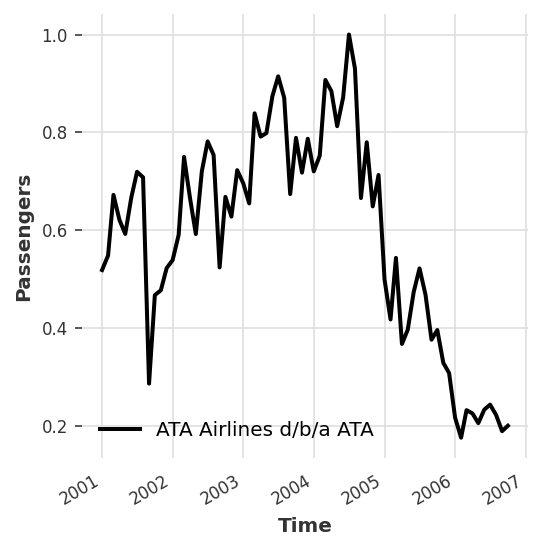

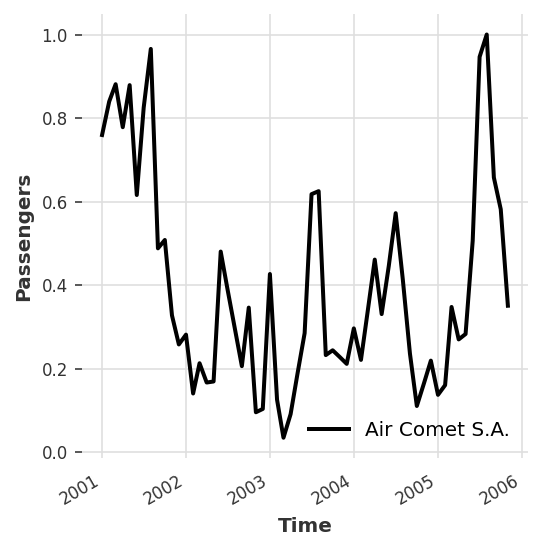

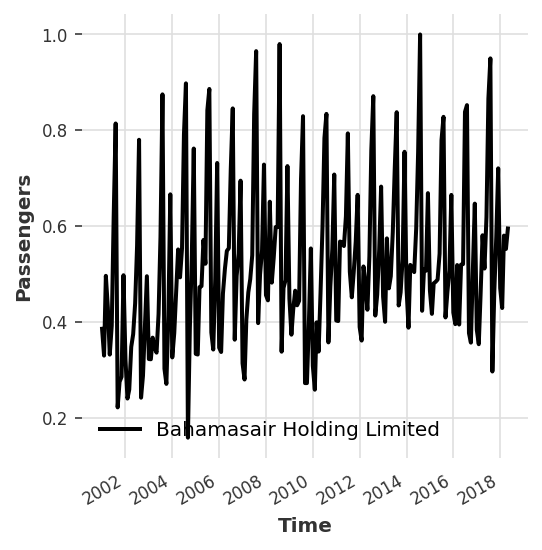

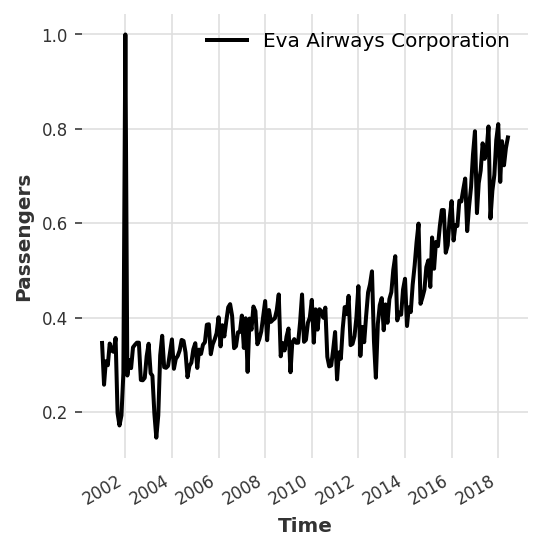

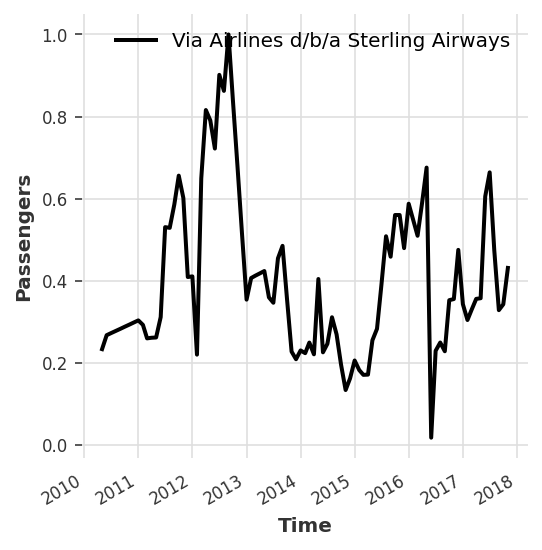

In [ ]:
for i in [1, 20, 50, 100, 250]:
    plt.figure(figsize=(4,4), dpi=144)
    air_train[i].plot(label=air_train[i].static_covariates.loc["passengers", "carrier_name"])
    plt.ylabel('Passengers')
    plt.xlabel('Time')
    plt.show()
    plt.close()

We can see that most series look quite different, and they even have different time axes. 

What is the smallest series available?

In [ ]:
min([len(ts) for ts in air_train])

31

Below, we write a small function that will make our life easier for quickly trying and comparing different local models. We loop through each serie, fit a model and then evaluate on our test dataset. 

> ⚠️ Please note `tq.tqdm` is optional and is only there to help display the training progress (as you will see it can take some time when training 300+ time series)


In [ ]:
def eval_local_model(train_series: List[TimeSeries], 
                     test_series: List[TimeSeries], 
                     model_cls, 
                     **kwargs) -> Tuple[List[float], float]:
    preds = []
    start_time = time.time()
    for series in tq.tqdm(train_series):
        model = model_cls(**kwargs)
        model.fit(series)
        pred = model.predict(n=HORIZON)
        preds.append(pred)
    elapsed_time = time.time() - start_time
    smapes = eval_forecasts(preds, test_series)
    return smapes, elapsed_time

We can now try a first forecasting model on this dataset. As a first step, it is usually a good practice to see how a (very) naive model blindly repeating the last value of the training series performs. This can be done in Darts using a [NaiveSeasonal](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.baselines.html#darts.models.forecasting.baselines.NaiveSeasonal) model:

  0%|          | 0/150 [00:00<?, ?it/s]

0.061996497
computing sMAPEs...
Avg sMAPE: 26.418 +- 21.811


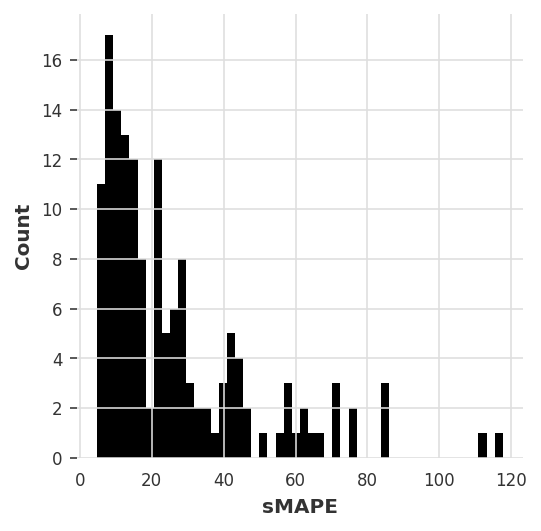

In [ ]:
naive_seasonal_last_smapes, naive_seasonal_last_elapsed_time  = eval_local_model(air_train, air_test, NaiveSeasonal, K=1)

So the most naive model gives us a sMAPE of about 39.38.

Can we do better with a "less naive" model exploiting the fact that most monthly series have a seasonality of 12?

  0%|          | 0/150 [00:00<?, ?it/s]

0.0022183305
computing sMAPEs...
Avg sMAPE: 22.650 +- 21.347


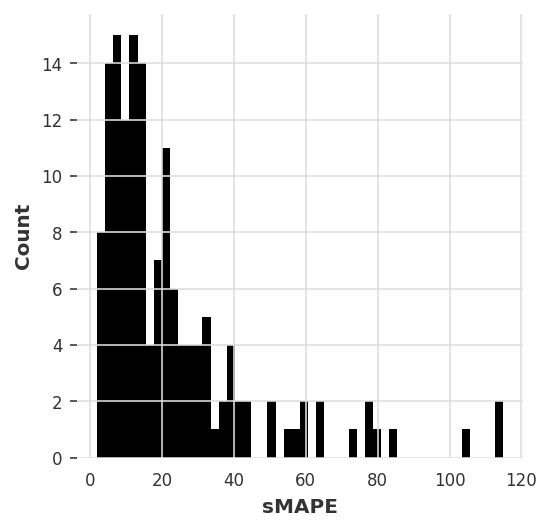

In [ ]:
naive_seasonal_monthly_smapes, naive_seasonal_monthly_elapsed_time = eval_local_model(air_train, air_test, NaiveSeasonal, K=12)

📈 We now have a sMAPE of 34.47 which is already an improvement. 

Let's now try a more complicated statistical model, the [ExponentialSmoothing](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.exponential_smoothing.html) model. By default, the seasonality of this model will be inferred from the frequency of the series (and set to 12).

  0%|          | 0/150 [00:00<?, ?it/s]

-0.21429083236225432
computing sMAPEs...
Avg sMAPE: 22.065 +- 23.070


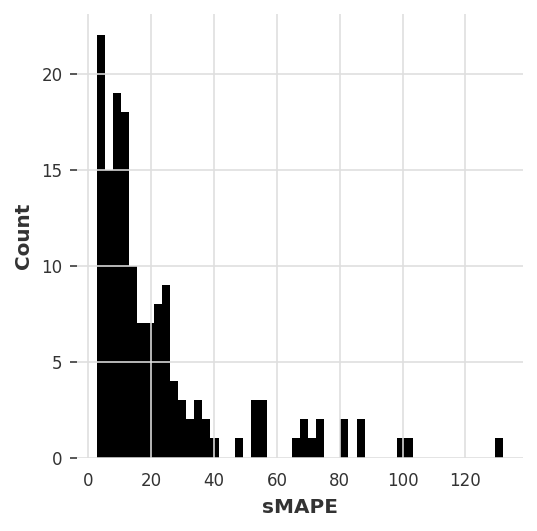

In [ ]:
naive_exponential_smoothing_smapes, naive_exponential_smoothing_elapsed_time = eval_local_model(air_train, air_test, ExponentialSmoothing)

  0%|          | 0/150 [00:00<?, ?it/s]

-0.21429083236225432
computing sMAPEs...
Avg sMAPE: 22.065 +- 23.070


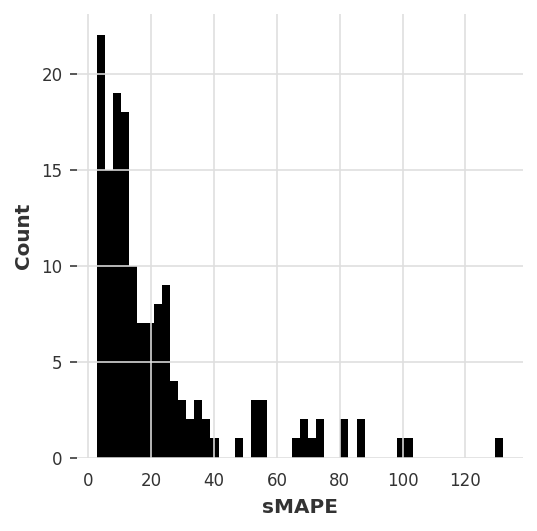

In [ ]:
naive_exponential_smoothing_smapes, naive_exponential_smoothing_elapsed_time = eval_local_model(air_train, air_test, ExponentialSmoothing)

Can we find better hyper-parameters for ExponentialSmoothing? You can head to the [API documentation](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.exponential_smoothing.html) to see what parameters it accepts.

  0%|          | 0/150 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


-2.6210962674467235
computing sMAPEs...
Avg sMAPE: 20.824 +- 24.967


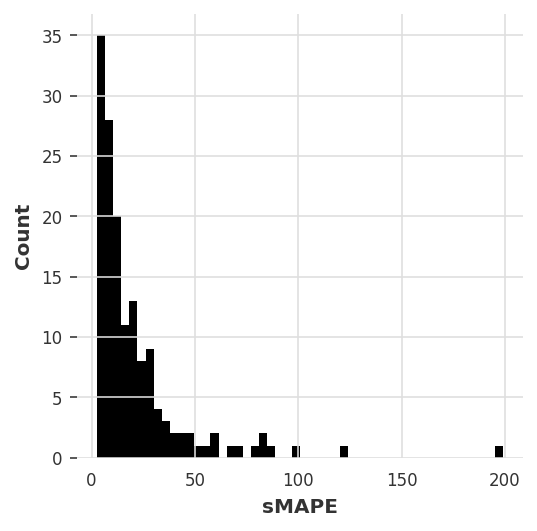

In [ ]:
exponential_smoothing_smapes, exponential_smoothing_elapsed_time = eval_local_model(air_train, air_test, ExponentialSmoothing, seasonal=SeasonalityMode.MULTIPLICATIVE, damped=True)

  0%|          | 0/150 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


-2.6210962674467235
computing sMAPEs...
Avg sMAPE: 20.824 +- 24.967


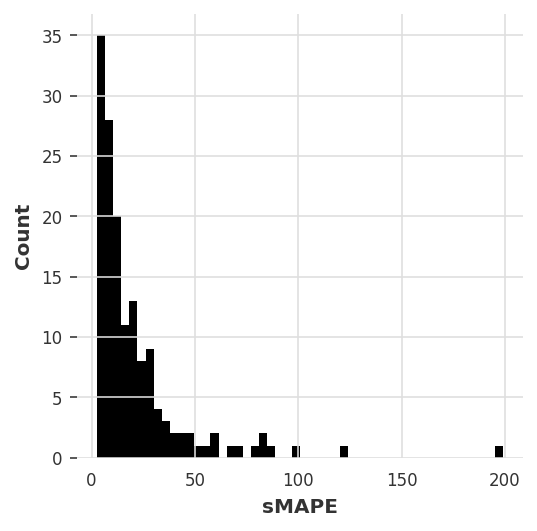

In [ ]:
exponential_smoothing_smapes, exponential_smoothing_elapsed_time = eval_local_model(air_train, air_test, ExponentialSmoothing, seasonal=SeasonalityMode.MULTIPLICATIVE, damped=True)

Let's try ARIMA now. This is often the best model, but it takes more time to fit... don't hesitate to interrupt the execution if it takes too long, or try it only on a subset of the data. Using `p=12`, `d=1` and `q=1` should do quite good here.

  0%|          | 0/150 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

-0.10528614197588053
computing sMAPEs...
Avg sMAPE: 20.774 +- 22.716


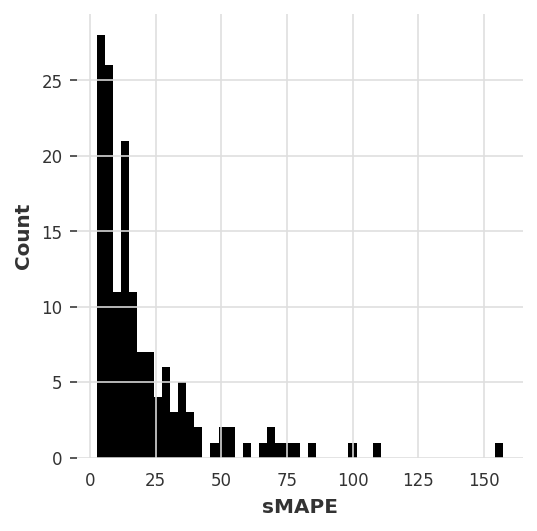

In [ ]:
arima_smapes, arima_elapsed_time = eval_local_model(air_train, air_test, ARIMA, p=12, d=1, q=1)

  0%|          | 0/150 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

-0.10528614197588053
computing sMAPEs...
Avg sMAPE: 20.774 +- 22.716


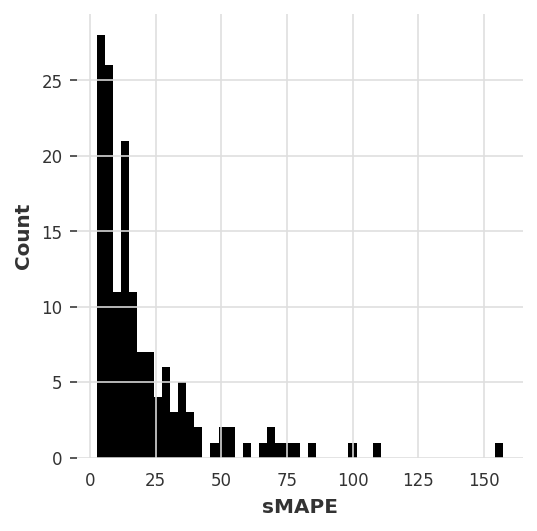

In [ ]:
arima_smapes, arima_elapsed_time = eval_local_model(air_train, air_test, ARIMA, p=12, d=1, q=1)

📈 ARIMA is performing a bit better than our Naive model but not by so much

Finally let's try a last model, called Theta model:

  0%|          | 0/150 [00:00<?, ?it/s]

-0.025228740823066663
computing sMAPEs...
Avg sMAPE: 22.440 +- 20.780


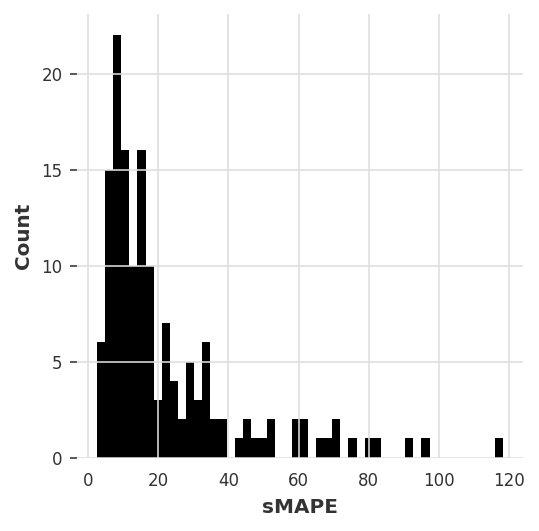

In [ ]:
theta_smapes, theta_elapsed_time = eval_local_model(air_train, air_test, Theta, theta=3)

We now give an overview of the sMAPEs and time to predict. On the boxplot the medians are displayed

In [ ]:
def smapes_boxplot(method_to_smapes: Dict[str, List[float]], title: str):
  method_names = []
  smapes = []
  for curr_method_name, curr_smapes in method_to_smapes.items():
    method_names += [curr_method_name] * len(curr_smapes)
    smapes += curr_smapes
  smapes_df = pd.DataFrame({'Method': method_names, 'sMAPE': smapes})
  plt.figure(figsize=(7,4), dpi=144)
  ax = sns.boxplot(x="Method", y="sMAPE", data=smapes_df)
  ax.grid(False)
  # Display median score on each box
  medians = smapes_df.groupby(['Method'])['sMAPE'].median().round(decimals=2)
  vertical_offset = smapes_df['sMAPE'].median() * 0.1
  for xtick, name in enumerate(method_to_smapes.keys()):
    ax.text(xtick, medians[name] + vertical_offset, medians[name], 
                  horizontalalignment='center', size='x-small', color='w', weight='semibold')
  plt.xticks(rotation=90) 
  plt.title(title) 
  plt.show()
  plt.close()

def elapsed_time_barplot(method_to_elapsed_times: Dict[str, float], title: str):
  elapsed_times_df = pd.DataFrame({'Method': method_to_elapsed_times.keys(), 'Elapsed time [s]': method_to_elapsed_times.values()})
  ax = plt.figure(figsize=(7,4), dpi=144)
  sns.barplot(x="Method", y="Elapsed time [s]", data=elapsed_times_df)
  plt.xticks(rotation=90) 
  plt.title(title) 
  plt.show()
  plt.close()

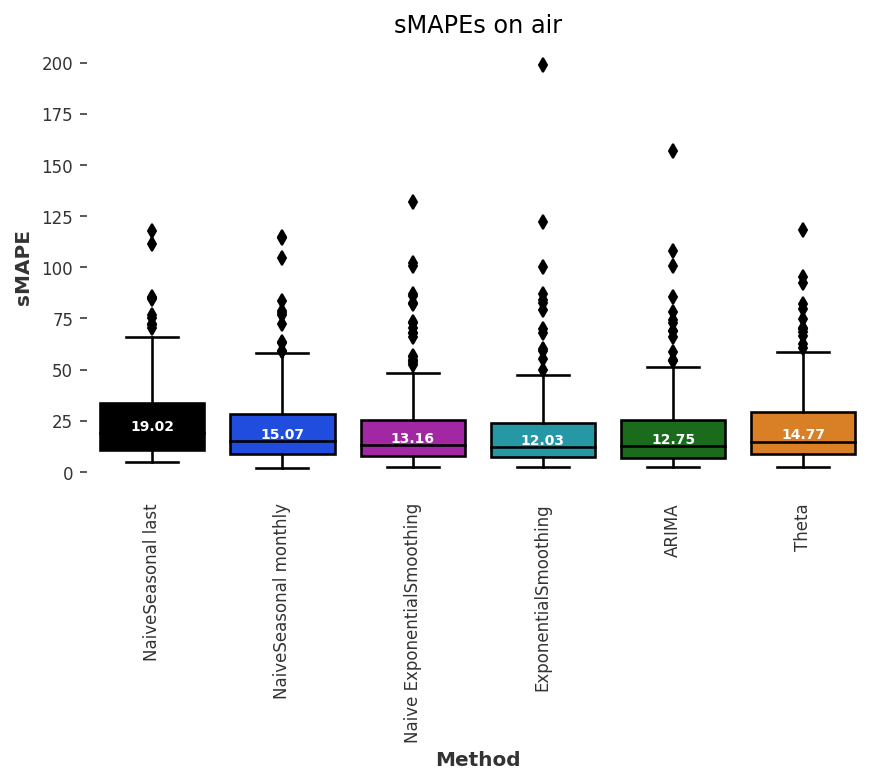

In [ ]:
smapes = {
    'NaiveSeasonal last': naive_seasonal_last_smapes,
    'NaiveSeasonal monthly': naive_seasonal_monthly_smapes,
    'Naive ExponentialSmoothing': naive_exponential_smoothing_smapes,
    'ExponentialSmoothing': exponential_smoothing_smapes,
    'ARIMA': arima_smapes,
    'Theta': theta_smapes,
}
smapes_boxplot(smapes, title='sMAPEs on air')

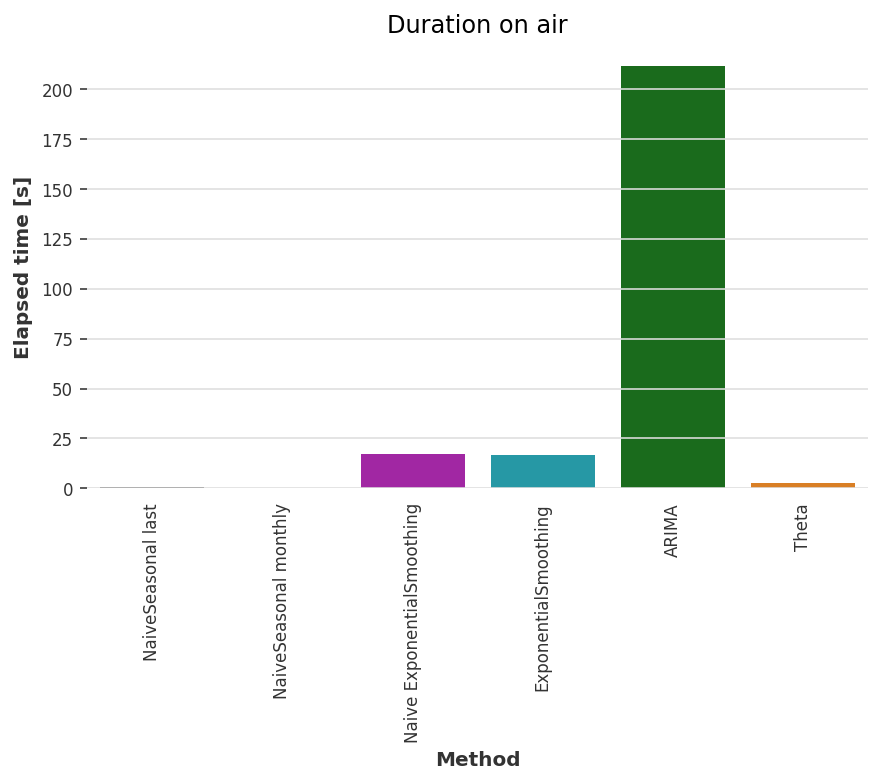

In [ ]:
elapsed_times = {
    'NaiveSeasonal last': naive_seasonal_last_elapsed_time,
    'NaiveSeasonal monthly': naive_seasonal_monthly_elapsed_time,
    'Naive ExponentialSmoothing': naive_exponential_smoothing_elapsed_time,
    'ExponentialSmoothing': exponential_smoothing_elapsed_time,
    'ARIMA': arima_elapsed_time,
    'Theta': theta_elapsed_time,
}
elapsed_time_barplot(elapsed_times, title='Duration on air')

### Conclusions so far:
On this dataset, doing significantly better than a naive seasonal model looks quite difficult. Some models do better than others but can also take longer to train (up to ~5 minutes on 300 series).

Can you try plotting some of the forecasts to visualise them?

## Part 2: Global models on the `air` dataset
### Part 2.1: Using Darts `RegressionModel`s.
`RegressionModel` in Darts are forecasting models that can wrap around any "scikit-learn compatible" regression model to obtain forecasts. In addition, Darts also offers some "pre-packaged" regression models such as `LinearRegressionModel` and `LightGBMModel`. Here's what it looks like with a `LinearRegressionModel`:

computing sMAPEs...
Avg sMAPE: 20.997 +- 21.686


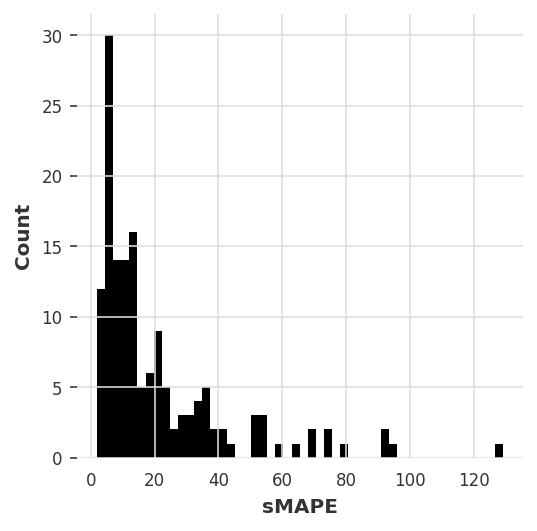

In [ ]:
# lags + output_chunk_length should not be larger than 
# the shortest training series (36). Lags can also be
# specified individually... see API doc.
start_time = time.time()
model = LinearRegressionModel(lags=24, output_chunk_length=12, use_static_covariates=False)
model.fit(air_train)
lr_preds = model.predict(series=air_train, n=HORIZON)
lr_elapsed_time = time.time() - start_time
lr_smapes = eval_forecasts(lr_preds, air_test)

computing sMAPEs...
Avg sMAPE: 23.285 +- 20.893


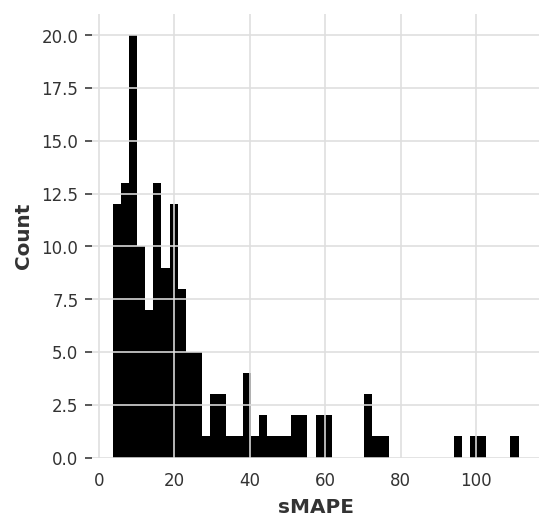

In [ ]:
start_time = time.time()
model = LightGBMModel(lags=24, output_chunk_length=12, use_static_covariates=False)
model.fit(air_train)
lgbm_preds = model.predict(series=air_train, n=HORIZON)
lgbm_elapsed_time = time.time() - start_time
lgbm_smapes = eval_forecasts(lgbm_preds, air_test)

computing sMAPEs...
Avg sMAPE: 21.015 +- 21.690


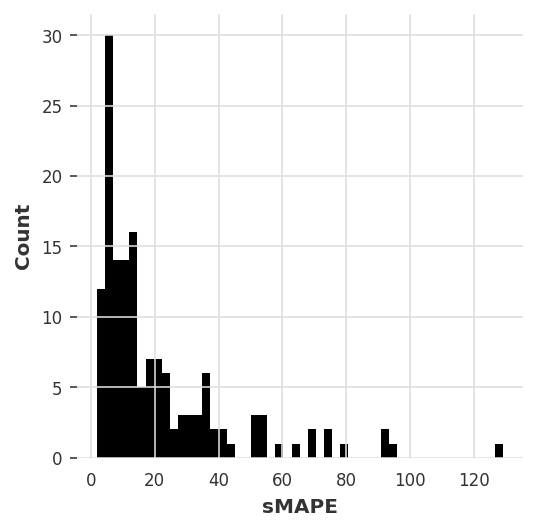

In [ ]:
start_time = time.time()
model = RegressionModel(model=Ridge(), lags=24, output_chunk_length=12, use_static_covariates=False)
model.fit(air_train);
ridge_preds = model.predict(series=air_train, n=HORIZON)
ridge_elapsed_time = time.time() - start_time
ridge_smapes = eval_forecasts(ridge_preds, air_test)

### Part 2.2: Using deep learning
Below, we will train an N-BEATS model on our `air` dataset.
The following hyper-parameters should be a good starting point, and training should take in the order of a minute.

In [ ]:
# Slicing hyper-params:
IN_LEN = 24
OUT_LEN = 12

# Architecture hyper-params:
NUM_STACKS = 18
NUM_BLOCKS = 3
NUM_LAYERS = 3
LAYER_WIDTH = 180
COEFFS_DIM = 6
LOSS_FN = SmapeLoss()

# Training settings:
LR = 5e-4
BATCH_SIZE = 1024
NUM_EPOCHS = 4


### Other possible hyper-params:
# NUM_STACKS = 16
# NUM_BLOCKS = 1
# NUM_LAYERS = 3
# LAYER_WIDTH = 256
# COEFFS_DIM = 12
# LOSS_FN = SmapeLoss()
# LR = 5e-5
# BATCH_SIZE = 1024
# NUM_EPOCHS = 8

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | SmapeLoss        | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 3.9 M 
---------------------------------------------------
3.9 M     Trainable params
1.3 K     Non-trainable params
3.9 M     Total params
15.570    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

computing sMAPEs...
Avg sMAPE: 21.790 +- 21.003


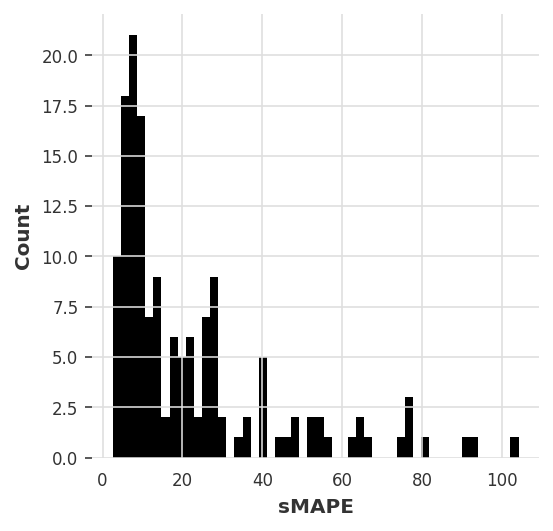

In [ ]:
# reproducibility
np.random.seed(42)
torch.manual_seed(42)
start_time = time.time()
nbeats_model_air = NBEATSModel(input_chunk_length=IN_LEN,
                               output_chunk_length=OUT_LEN, 
                               batch_size=BATCH_SIZE,
                               nr_epochs_val_period=1,
                               num_stacks=NUM_STACKS,
                               num_blocks=NUM_BLOCKS,
                               num_layers=NUM_LAYERS,
                               layer_widths=LAYER_WIDTH,
                               expansion_coefficient_dim=COEFFS_DIM,
                               loss_fn=LOSS_FN,
                               optimizer_kwargs={'lr': LR},
                               pl_trainer_kwargs={"enable_progress_bar": True, 
                                                  "accelerator": "gpu"},
                               )

nbeats_model_air.fit(air_train,
                     num_loader_workers=1,
                     epochs=NUM_EPOCHS)

nb_preds = nbeats_model_air.predict(series=air_train, n=HORIZON)
nbeats_elapsed_time = time.time() - start_time
nbeats_smapes = eval_forecasts(nb_preds, air_test)

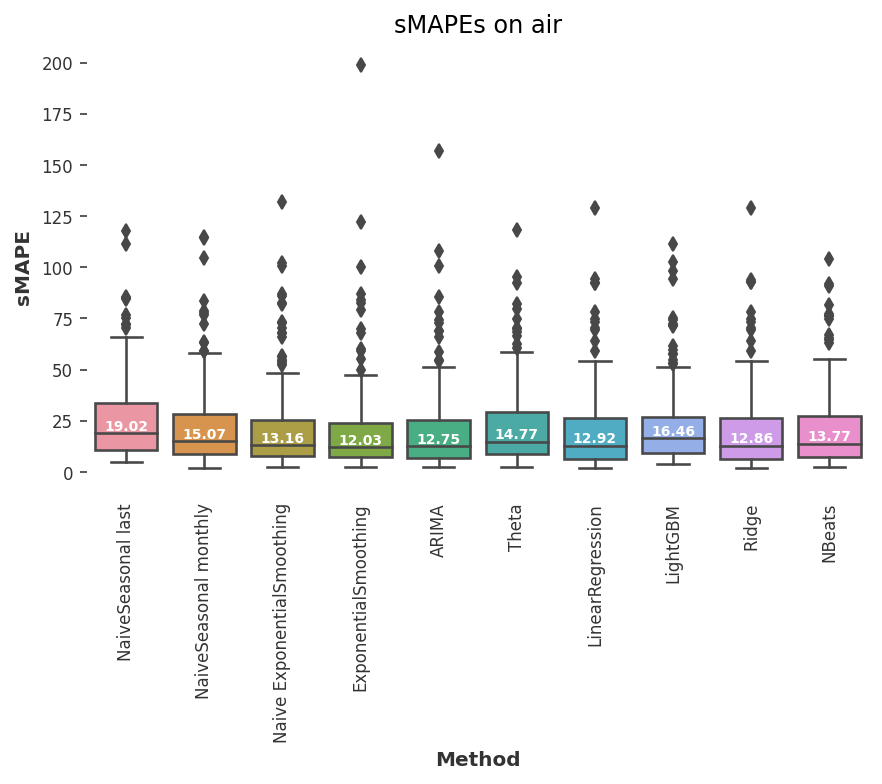

In [ ]:
smapes_2 = {**smapes,
    **{
    'LinearRegression': lr_smapes,
    'LightGBM': lgbm_smapes,
    'Ridge': ridge_smapes,
    'NBeats': nbeats_smapes,
    }
}
smapes_boxplot(smapes_2, title='sMAPEs on air')

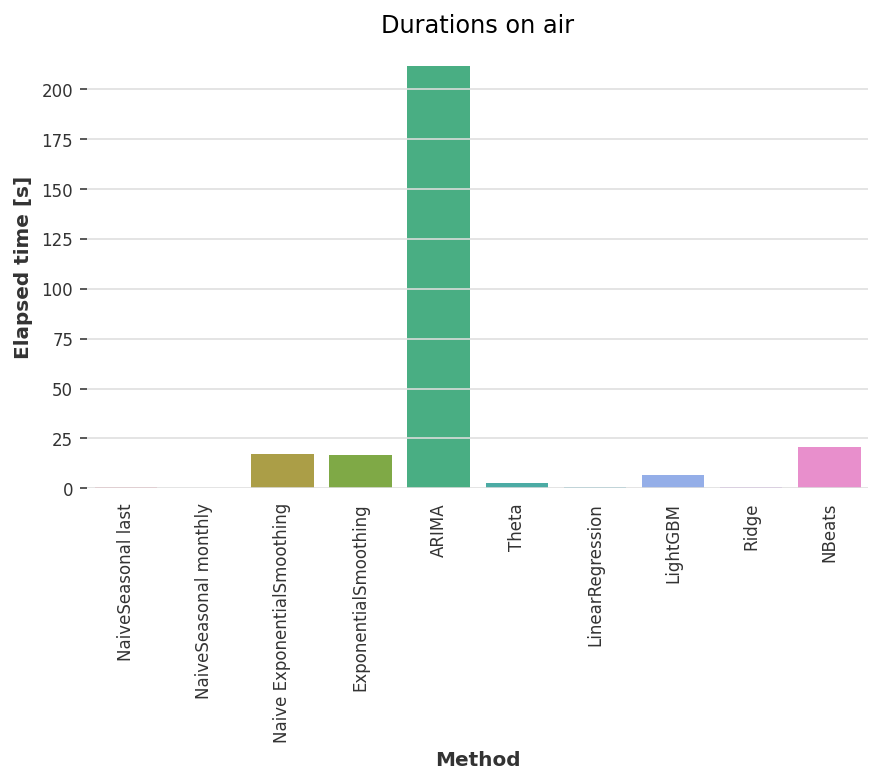

In [ ]:
elapsed_time_2 = {**elapsed_times,
    **{
    'LinearRegression': lr_elapsed_time,
    'LightGBM': lgbm_elapsed_time,
    'Ridge': ridge_elapsed_time,
    'NBeats': nbeats_elapsed_time,
    }
}
elapsed_time_barplot(elapsed_time_2, title='Durations on air')

### Conclusions so far
The global models can offer performance out of the box which is on par with the best local models, but in a way that is faster to train, and a bit simpler to use. The deep learning model we proposed here does not do better than the competition. Maybe it is because we didn't have enough data to train it...

## Part 3: Training an N-BEATS model on `m4` dataset and use it to forecast `air` dataset
Deep learning models often do better when trained on *large* datasets. Let's try to load all 48,000 monthly time series in the M4 dataset and train our model once more.

In [ ]:
m4_train, m4_test = load_m4()

# filter to keep only those that are long enough
filtered = filter(lambda t: len(t[0]) >= 48, zip(m4_train, m4_test))
m4_train, m4_test = zip(*filtered)
m4_train, m4_test = list(m4_train), list(m4_test)

print('There are {} series of length >= 48.'.format(len(m4_train)))

loading M4 TimeSeries...
done. There are 48000 series, with average training length 216.30022916666667
There are 47992 series of length >= 48.


We can start from the same hyper-parameters as before. 

With 48,000 M4 training series being on average ~200 time steps long, we would end up with ~10M training samples. With such a number of training samples, each epoch would take too long. So here, we'll limit the number of training samples used per series. This is done when calling `fit()` with the parameter `max_samples_per_ts`. We add a new hyper-parameter `MAX_SAMPLES_PER_TS` to capture this.

Since the M4 training series are all >= 48 time steps long, we can also use a longer `input_chunk_length` of 36.

In [ ]:
# Slicing hyper-params:
IN_LEN = 36
OUT_LEN = 12

# Architecture hyper-params:
NUM_STACKS = 18
NUM_BLOCKS = 3
NUM_LAYERS = 3
LAYER_WIDTH = 180
COEFFS_DIM = 6
LOSS_FN = SmapeLoss()

# Training settings:
LR = 5e-4
BATCH_SIZE = 1024
MAX_SAMPLES_PER_TS = 8   # <-- new param, limiting nr of training samples per epoch
NUM_EPOCHS = 7

In [ ]:
# reproducibility
np.random.seed(42)
torch.manual_seed(42)

nbeats_model_m4 = NBEATSModel(input_chunk_length=IN_LEN,
                               output_chunk_length=OUT_LEN, 
                               batch_size=BATCH_SIZE,
                               nr_epochs_val_period=1,
                               num_stacks=NUM_STACKS,
                               num_blocks=NUM_BLOCKS,
                               num_layers=NUM_LAYERS,
                               layer_widths=LAYER_WIDTH,
                               expansion_coefficient_dim=COEFFS_DIM,
                               loss_fn=LOSS_FN,
                               optimizer_kwargs={'lr': LR},
                               pl_trainer_kwargs={"enable_progress_bar": True, 
                                                  "accelerator": "gpu"},
                               )

In [ ]:
# Train
nbeats_model_m4.fit(m4_train,
                    num_loader_workers=1,
                    max_samples_per_ts=MAX_SAMPLES_PER_TS,
                    epochs=NUM_EPOCHS)

# Load already trained model
# !curl -L https://github.com/unit8co/amld2022-forecasting-and-metalearning/blob/main/data/nbeats_model_m4.pth.tar\?raw\=true -o nbeats_model_m4.pth.tar
# nbeats_model_m4 = nbeats_model_m4.load_from_checkpoint('nbeats_model_m4.pth.tar')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | SmapeLoss        | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 4.0 M 
---------------------------------------------------
4.0 M     Trainable params
1.3 K     Non-trainable params
4.0 M     Total params
16.055    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=7` reached.


NBEATSModel(generic_architecture=True, num_stacks=18, num_blocks=3, num_layers=3, layer_widths=180, expansion_coefficient_dim=6, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=36, output_chunk_length=12, batch_size=1024, nr_epochs_val_period=1, loss_fn=SmapeLoss(), optimizer_kwargs={'lr': 0.0005}, pl_trainer_kwargs={'enable_progress_bar': True, 'accelerator': 'gpu'})

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

computing sMAPEs...
Avg sMAPE: 21.494 +- 19.397


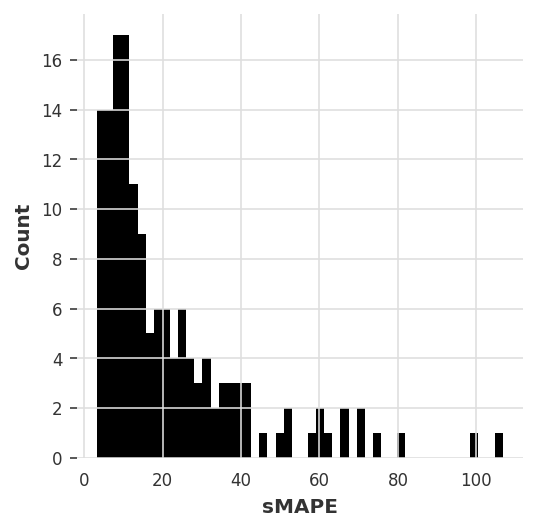

In [ ]:
start_time = time.time()
preds = nbeats_model_m4.predict(series=air_train, n=HORIZON)
nbeats_m4_elapsed_time = time.time() - start_time
nbeats_m4_smapes = eval_forecasts(preds, air_test)

Now, our M4-trained N-BEATS model can get to performance on par with the best models on the `air` dataset, *even though it has never been trained on any of the `air` series*.

### Try training other global models on `m4` and applying on airline passengers
Let's try to do the same thing with an LGBModel. We train it on a random subset of all M4 series otherwise it takes too long.

In [ ]:
# reproducibility
random.seed(42)

model_lgbm_m4 = LightGBMModel(lags=36, output_chunk_length=12, objective='mape')
model_lgbm_m4.fit(random.choices(m4_train, k=10000), max_samples_per_ts=8);

computing sMAPEs...
Avg sMAPE: 22.980 +- 21.173


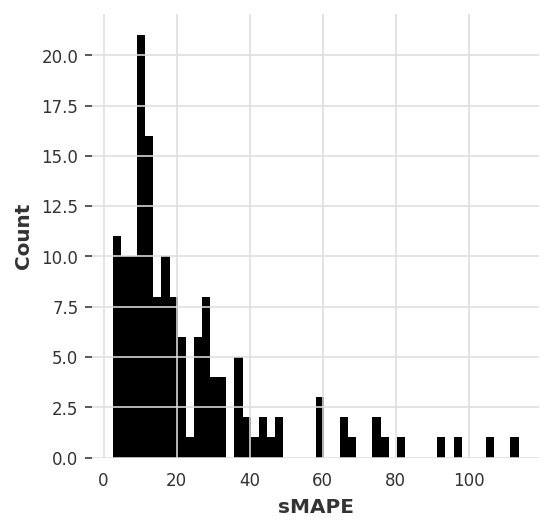

In [ ]:
start_time = time.time()
preds = model_lgbm_m4.predict(series=air_train, n=HORIZON)
lgbm_m4_elapsed_time = time.time() - start_time
lgbm_m4_smapes = eval_forecasts(preds, air_test)

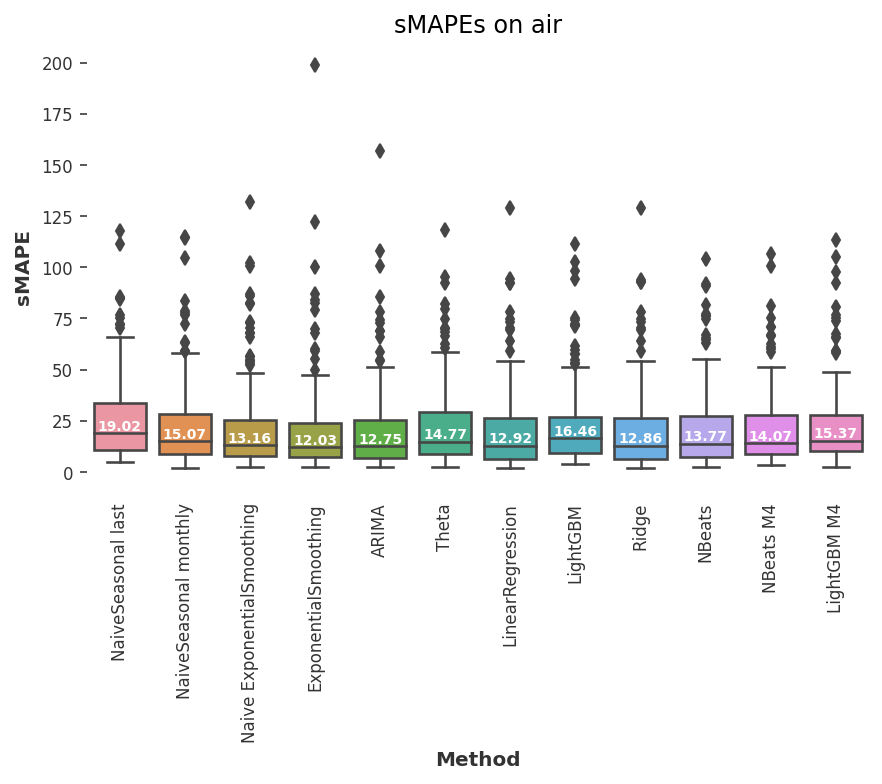

In [ ]:
smapes_3 = {**smapes_2,
    **{
    'NBeats M4': nbeats_m4_smapes,
    'LightGBM M4': lgbm_m4_smapes,
    }
}
smapes_boxplot(smapes_3, title='sMAPEs on air')

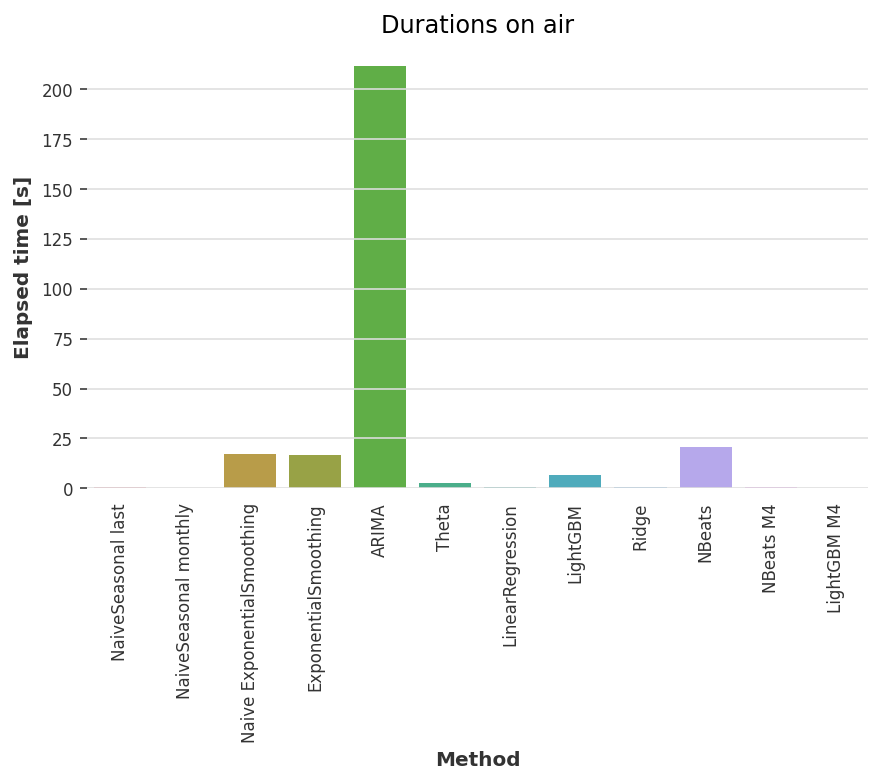

In [ ]:
elapsed_time_3 = {**elapsed_time_2,
    **{
    'NBeats M4': nbeats_m4_elapsed_time,
    'LightGBM M4': lgbm_m4_elapsed_time,
    }
}
elapsed_time_barplot(elapsed_time_3, title='Durations on air')

### Visualizing timeseries


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


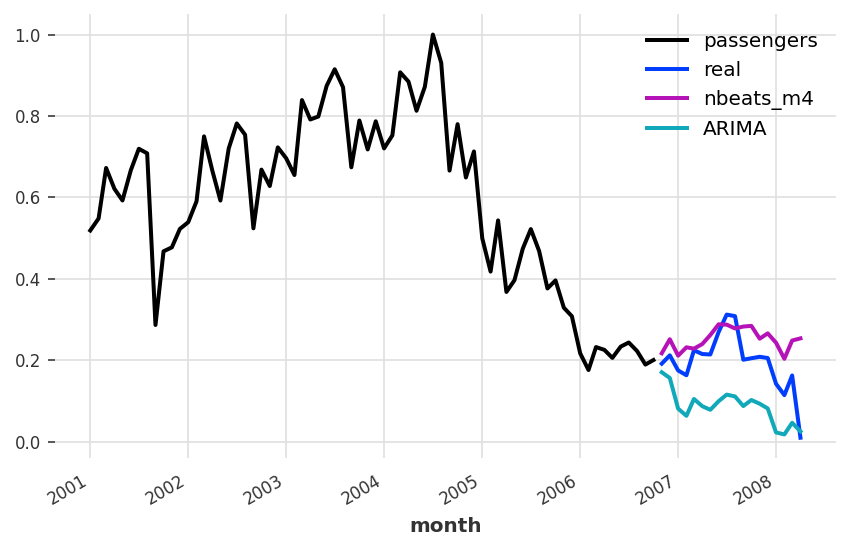

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


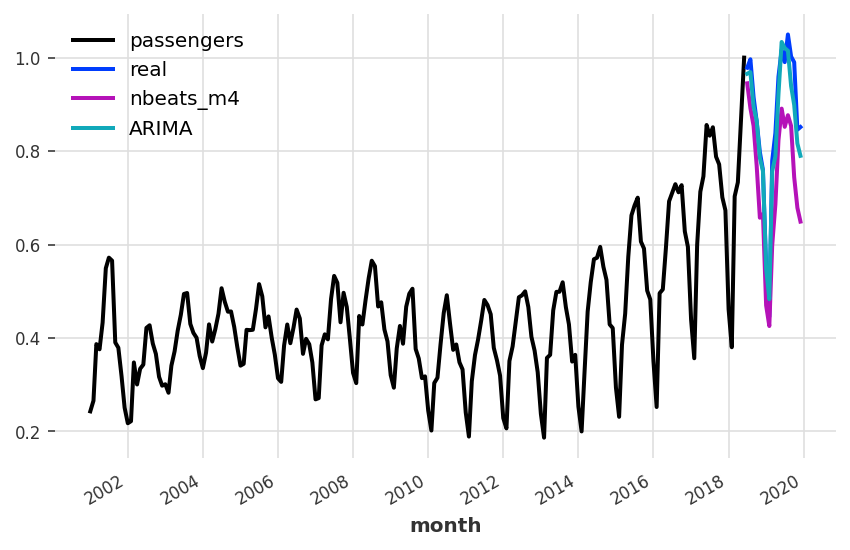

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


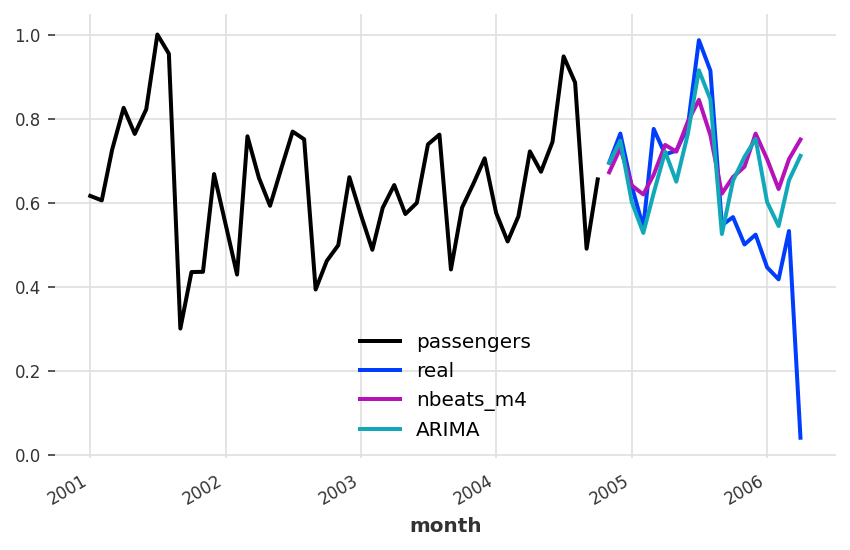

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


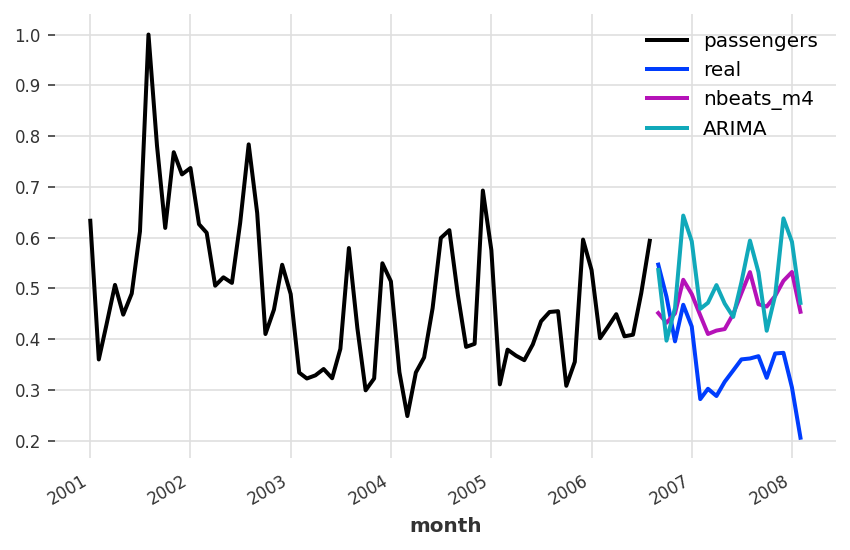

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


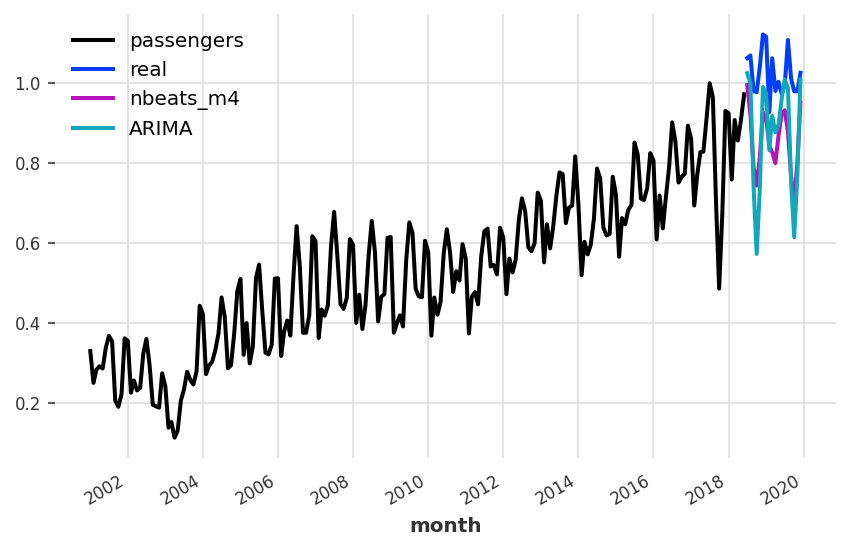

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


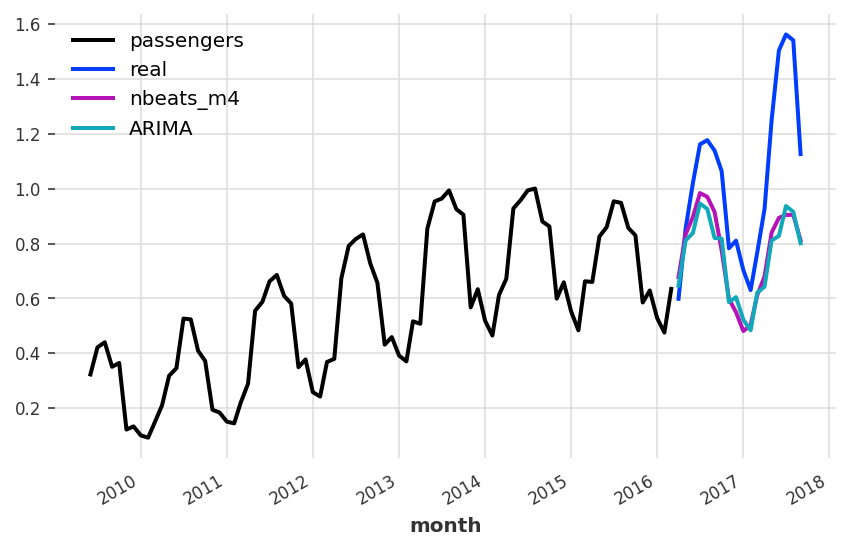

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


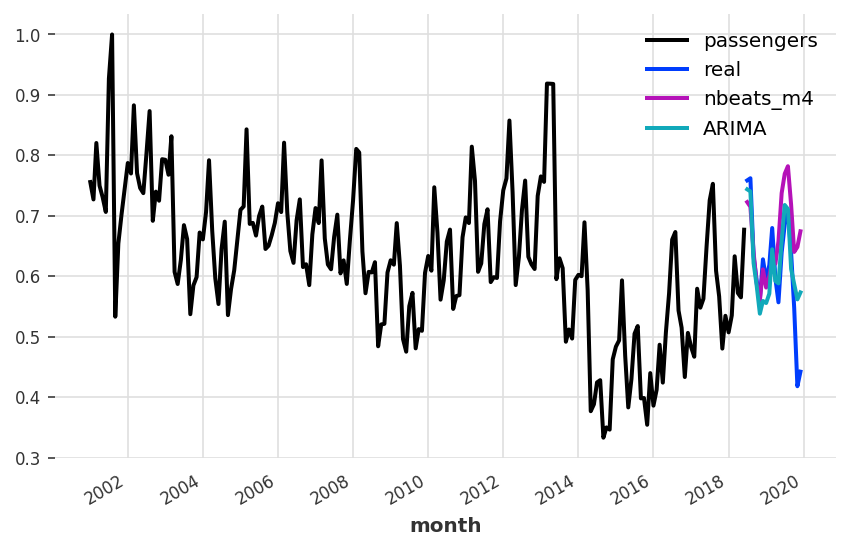

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


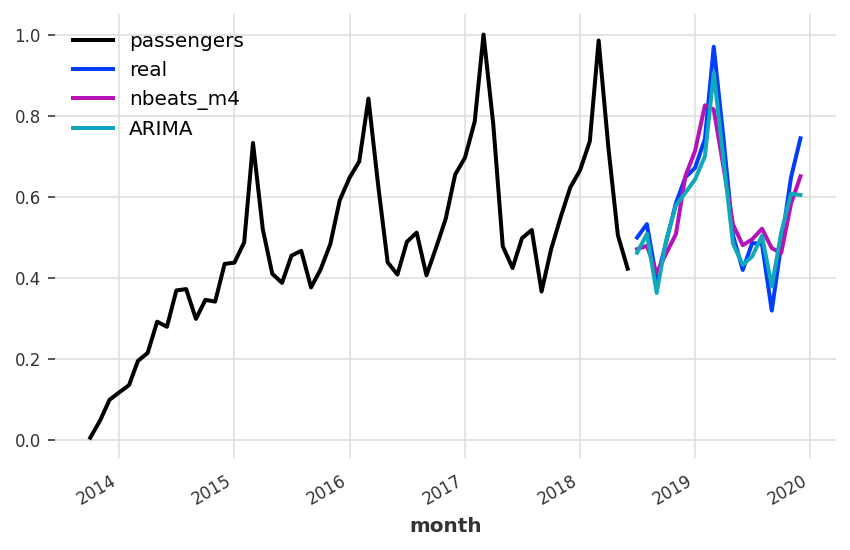

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

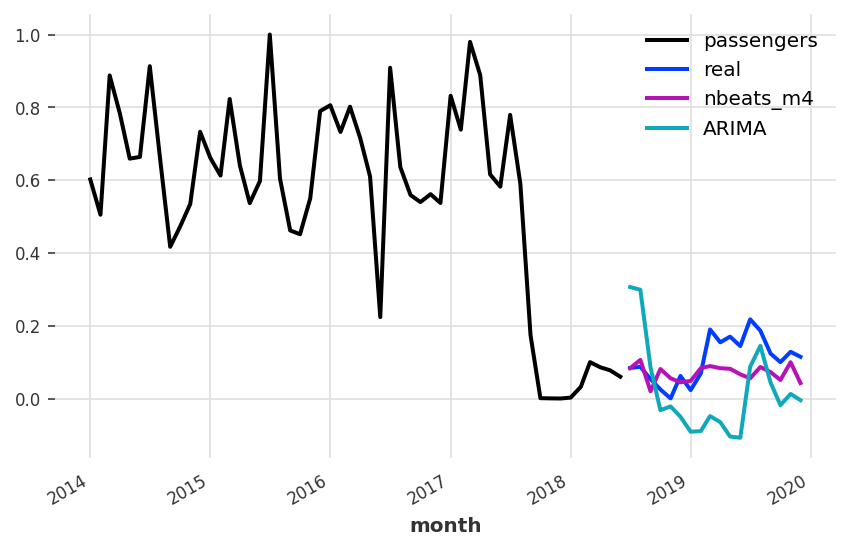

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


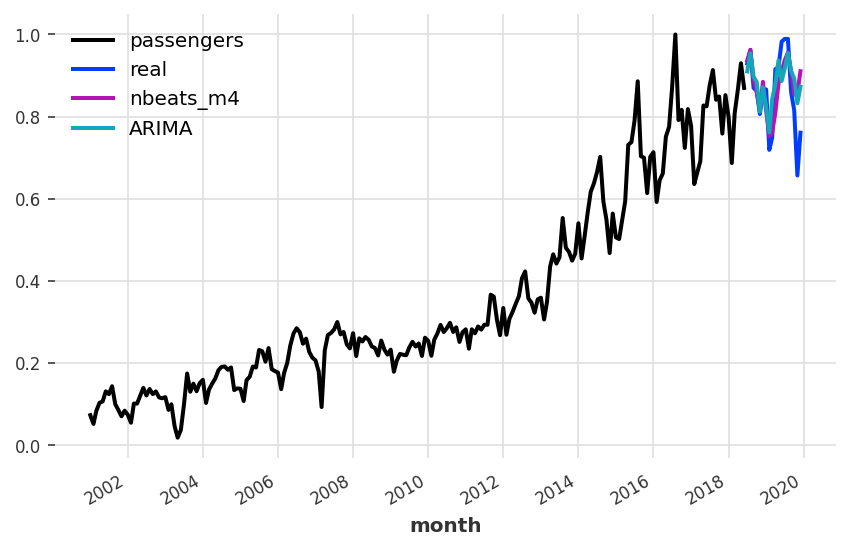

In [ ]:
def pred(model_cls, series, **kwargs):
  model = model_cls(**kwargs)
  model.fit(series)
  pred = model.predict(n=HORIZON)
  return pred

for i in range(10):
  _ = plt.figure(figsize=(7,4), dpi=144)
  air_train[i].plot()
  air_test[i].plot(label='real')
  nbeats_model_m4.predict(len(air_test[i]), series=air_train[i]).plot(label='nbeats_m4')
  pred(ARIMA, air_train[i], p=12, d=1, q=1).plot(label='ARIMA')
  plt.show()
  plt.close()

## Part 4: Forecasting the `m3` dataset

In [ ]:
m3_train, m3_test = load_m3()

building M3 TimeSeries...


0it [00:00, ?it/s]


There are 1399 monthly series in the M3 dataset
splitting train/test...
scaling...
done. There are 1399 series, with average training length 100.30092923516797


  0%|          | 0/1399 [00:00<?, ?it/s]

0.02023988
computing sMAPEs...
Avg sMAPE: 18.371 +- 19.262


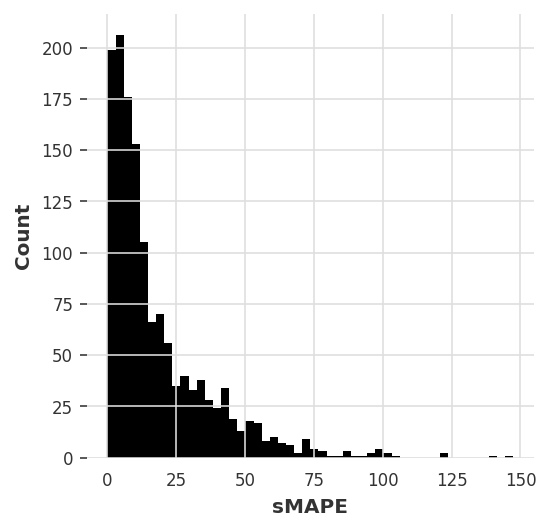

In [ ]:
naive_seasonal_last_smapes, naive_seasonal_last_elapsed_time = eval_local_model(m3_train, m3_test, NaiveSeasonal, K=1)

  0%|          | 0/1399 [00:00<?, ?it/s]

0.0037968676
computing sMAPEs...
Avg sMAPE: 17.262 +- 16.008


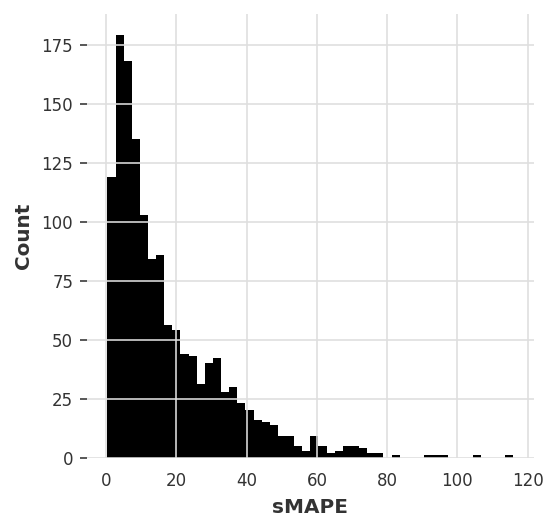

In [ ]:
naive_seasonal_monthly_smapes, naive_seasonal_monthly_elapsed_time = eval_local_model(m3_train, m3_test, NaiveSeasonal, K=12)

Let's see what we get with the Theta method, which was one of the winning methods developed in the context of M3!

  0%|          | 0/1399 [00:00<?, ?it/s]

-0.026474858607802344
computing sMAPEs...
Avg sMAPE: 14.921 +- 15.122


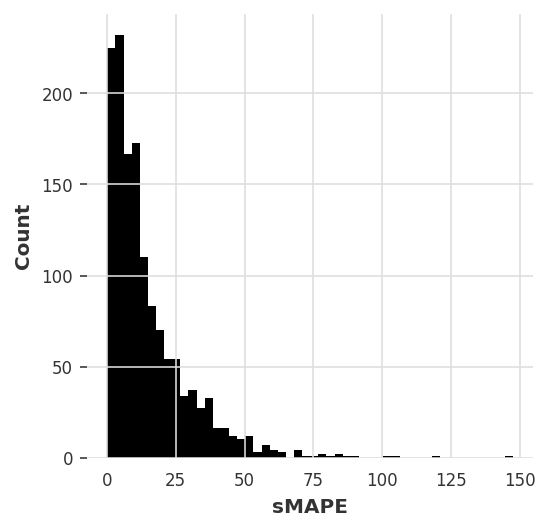

In [ ]:
theta_smapes, theta_elapsed_time = eval_local_model(m3_train, m3_test, Theta)

  0%|          | 0/1399 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


-0.2180314030697655
computing sMAPEs...
Avg sMAPE: 17.299 +- 19.072


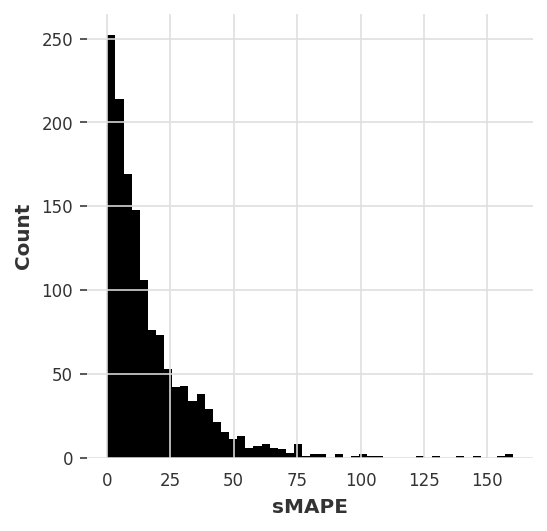

In [ ]:
exponential_smoothing_smapes, exponential_smoothing_elapsed_time = eval_local_model(m3_train, m3_test, ExponentialSmoothing, seasonal=SeasonalityMode.MULTIPLICATIVE, damped=True)

  0%|          | 0/1399 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

-0.025035055065589576
computing sMAPEs...
Avg sMAPE: 14.639 +- 15.202


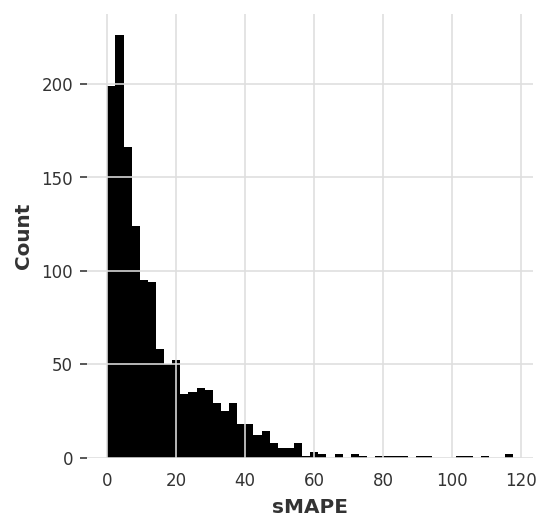

In [ ]:
arima_smapes, arima_elapsed_time = eval_local_model(m3_train, m3_test, ARIMA, p=12, d=1, q=1)

And what do we get with our N-BEATS model?

NEW

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

computing sMAPEs...
Avg sMAPE: 14.910 +- 13.851


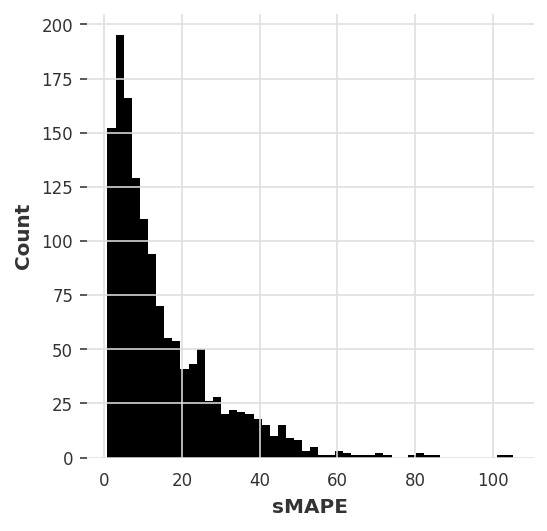

In [ ]:
start_time = time.time()
preds = nbeats_model_m4.predict(series=m3_train, n=HORIZON)
nbeats_m4_elapsed_time = time.time() - start_time
nbeats_m4_smapes = eval_forecasts(preds, m3_test)

OLD

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 375it [00:00, ?it/s]

computing sMAPEs...
Avg sMAPE: 14.879 +- 13.821


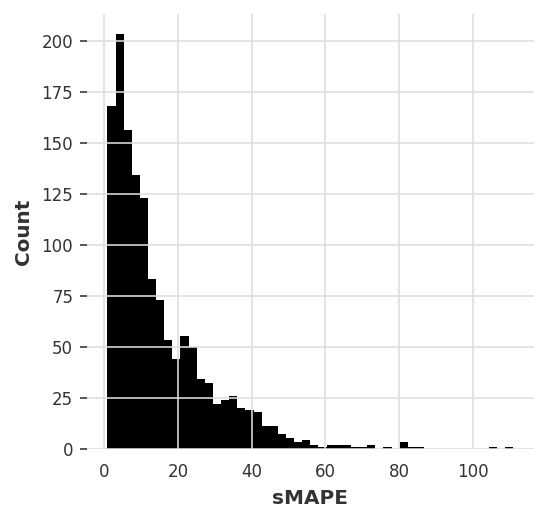

In [ ]:
start_time = time.time()
preds = nbeats_model_m4.predict(series=m3_train, n=HORIZON)
nbeats_m4_elapsed_time = time.time() - start_time
nbeats_m4_smapes = eval_forecasts(preds, m3_test)

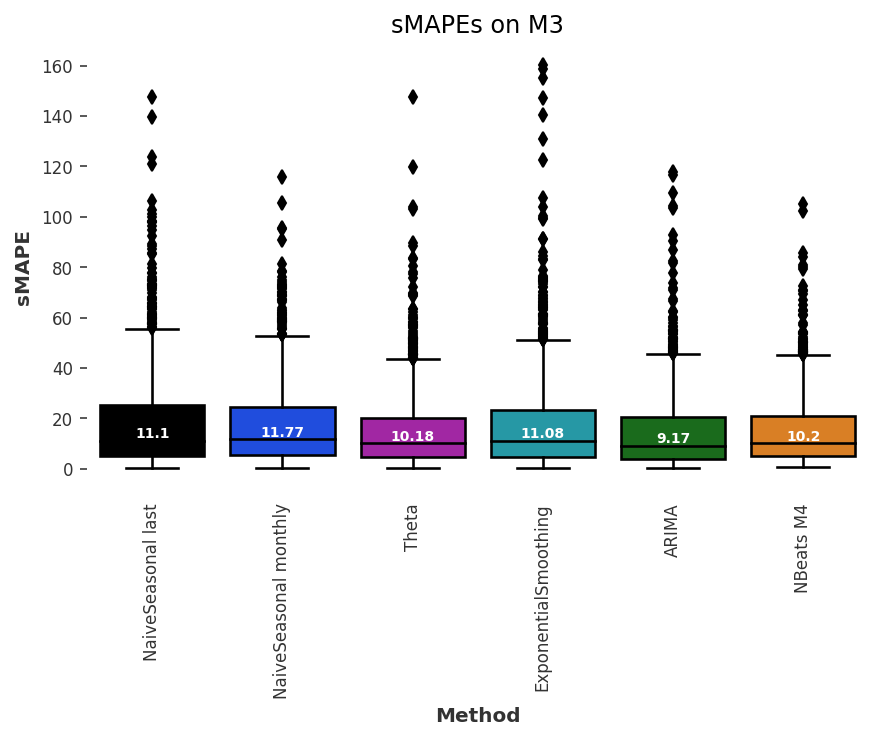

In [ ]:
smapes_4 = {
    'NaiveSeasonal last': naive_seasonal_last_smapes,
    'NaiveSeasonal monthly': naive_seasonal_monthly_smapes,
    'Theta': theta_smapes,
    'ExponentialSmoothing': exponential_smoothing_smapes,
    'ARIMA': arima_smapes,
    'NBeats M4': nbeats_m4_smapes
}
smapes_boxplot(smapes_4, title='sMAPEs on M3')

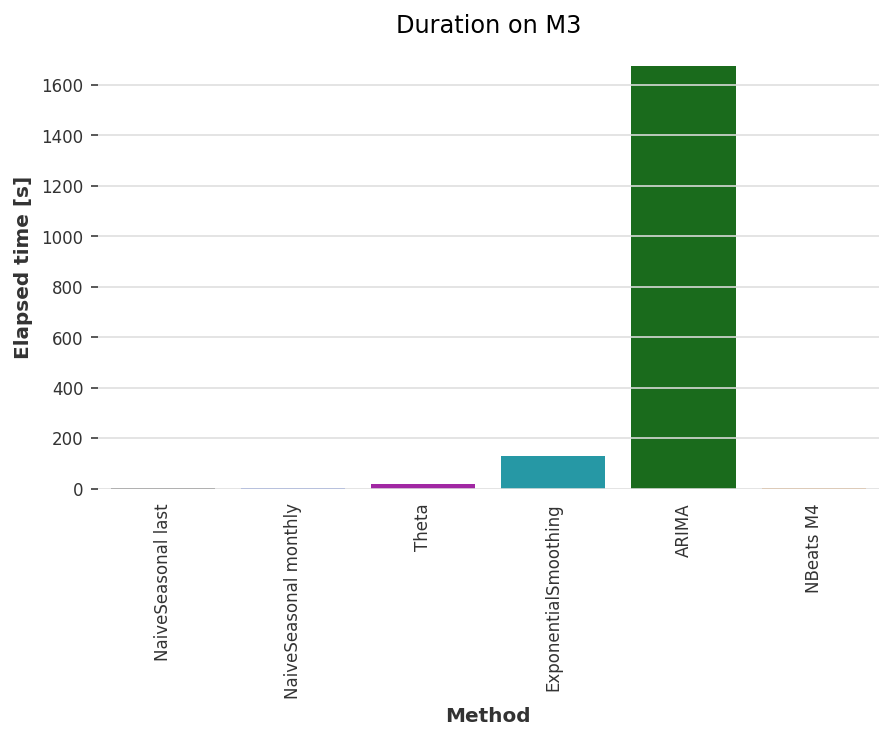

In [ ]:
elapsed_times_4 = {
    'NaiveSeasonal last': naive_seasonal_last_elapsed_time,
    'NaiveSeasonal monthly': naive_seasonal_monthly_elapsed_time,
    'Theta': theta_elapsed_time,
    'ExponentialSmoothing': exponential_smoothing_elapsed_time,
    'ARIMA': arima_elapsed_time,
    'NBeats M4': nbeats_m4_elapsed_time
}
elapsed_time_barplot(elapsed_times_4, title='Duration on M3')

## -- END --

# TODO
* Make a "participant-facing" version of the notebook
* Save a pre-trained version of M4-trained N-BEATS for participatns who cannot train it
* Visualise some of the predictions
* Provide some code snippets for participants who want to try different things:
  * Early stopping
  * Using HorizonBased Datasets
  * Hyper-param tuning using Optuna
  * ...

In [ ]:
nbeats_model_m4.save_model('nbeats_model_m4.pth.tar')

In [ ]:
# Some configs for M4 -> M3 transfer


##### This is a good start config 14.87 (~10 mins training time)
##### Also good on air passengers (32.381)

# Slicing hyper-params:
IN_LEN = 36
OUT_LEN = 12

# Architecture hyper-params:
NUM_STACKS = 18
NUM_BLOCKS = 3
NUM_LAYERS = 3
LAYER_WIDTH = 180
COEFFS_DIM = 6

# Training settings:
LR = 5e-4  # 5e-5
BATCH_SIZE = 1024
MAX_SAMPLES_PER_TS = 8
NUM_EPOCHS = 4


################# Other possible configs: #################

#### 14.83 - 13 minutes
# IN_LEN = 36
# OUT_LEN = 12
# NUM_STACKS = 8
# NUM_BLOCKS = 3
# NUM_LAYERS = 4
# LAYER_WIDTH = 183
# COEFFS_DIM = 14
# LR = 0.0005247859772945128
# BATCH_SIZE = 1024
# MAX_SAMPLES_PER_TS = 13
# NUM_EPOCHS = 4


#### 14.80
# IN_LEN = 36
# OUT_LEN = 12
# NUM_STACKS = 18
# NUM_BLOCKS = 3
# NUM_LAYERS = 3
# LAYER_WIDTH = 180
# COEFFS_DIM = 6
# LR = 5e-4 
# BATCH_SIZE = 1024
# MAX_SAMPLES_PER_TS = 8
# NUM_EPOCHS = 6